# po(n)g

In [2]:
import numpy as np
import torch 
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

import gymnasium as gym
import ale_py
gym.register_envs(ale_py)

from IPython.display import display, Code, clear_output

device = torch.device("mps")

spin up the RL env

In [2]:
env = gym.make("ALE/Pong-v5", obs_type='grayscale', render_mode='rgb_array')
observation = env.reset()
env.render();

A.L.E: Arcade Learning Environment (version 0.9.1+aff5939)
[Powered by Stella]


In [3]:
ymin, ymax = 34, 194

In [4]:
observation

(array([[  0,   0,   0, ..., 107, 107, 107],
        [107, 107, 107, ..., 107, 107, 107],
        [107, 107, 107, ..., 107, 107, 107],
        ...,
        [ 74,  74,  74, ...,  74,  74,  74],
        [ 74,  74,  74, ...,  74,  74,  74],
        [ 74,  74,  74, ...,  74,  74,  74]], dtype=uint8),
 {'lives': 0, 'episode_frame_number': 0, 'frame_number': 0})

In [4]:
def get_model_input(obs):
    screen = obs
    truncated = screen[ymin:ymax]
    blanked = truncated
    blanked[blanked == obs[0, 0]] = 0
    downsampled = torch.from_numpy(blanked[::2, ::2])

    # convert to floats, clamped 0-1
    flt = downsampled.float()
    return (flt / 255).flatten().to(device)

In [56]:
obs1, *_ = env.step(NOOP)
obs2, *_ = env.step(NOOP)
obs3, *_ = env.step(NOOP)
obs4, *_ = env.step(NOOP)

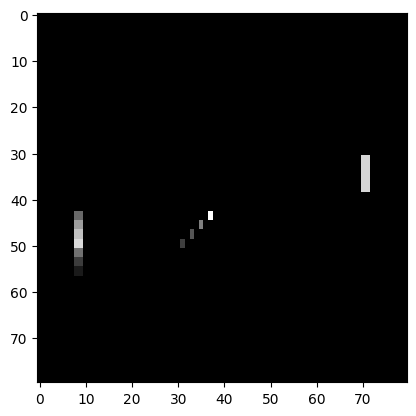

In [58]:
plt.imshow(get_model_input(obs1 + obs2/2 + obs3/3 + obs4/4).view(80, 80), cmap='gray')

0.0 [False, False, {'lives': 0, 'episode_frame_number': 4, 'frame_number': 4}]


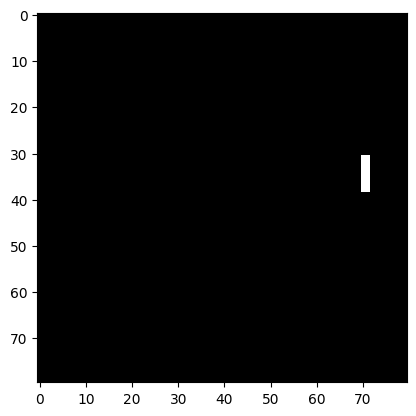

In [20]:
observation, reward, *x = env.step(NOOP)
print(reward, x)
plt.imshow(get_model_input(observation).view(80, 80), cmap='gray')

In [5]:
# the deep Q network.
# the output will be a single probability representing P(go up).
n_embd = 50

class Qnn(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        
        self.n_embd = n_embd

        # (B, 80*80) -> (B, n_embd)
        self.l1 = nn.Linear(80*80, n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        # (B, n_embd) -> (B, 2)
        # interpret the output as logits for UP, DOWN, NOOP
        self.l2 = nn.Linear(n_embd, 3)
        self.ln2 = nn.LayerNorm(3)

    def forward(self, x):
        y = (x - torch.mean(x)) / torch.var(x)**0.5
        y = self.l1(y)
        y = self.ln1(y)
        y = F.gelu(y)
        y = self.l2(y)
        y = self.ln2(y)
        return F.gelu(y)

In [37]:
network = Qnn(n_embd)
network = network.to(device)

In [42]:
UP = 2
DOWN = 3
NOOP = 0

# fig = plt.figure(figsize=(15, 7))
# ax = fig.add_subplot(1, 1, 1)

# chart = display(fig, display_id=True)

def run_episode(model, env, gamma=0.8):
    obs1 = env.reset()[0]
    obs2, reward, *_ = env.step(NOOP)
    obs3, *_ = env.step(NOOP)
    obs4, *_ = env.step(NOOP)

    # run until we score or lose
    action_indices = []
    all_probs = []
    total_reward = 0.0
    stepi = 0
    while stepi < 500:
        stepi += 1
        
        x = get_model_input(obs1 + obs2/2 + obs3/3 + obs4/4)
        logits = model(x)

        # sample from Pi(s, a)
        probs = F.softmax(logits, dim=-1)
        all_probs.append(probs)
        
        action_idx = torch.multinomial(probs, 1).item()
        action_indices.append(action_idx)

        # evaluate the Q-fn
        obs1 = obs2
        obs2 = obs3
        obs3 = obs4
        obs4, reward, *_ = env.step({0: UP, 1: DOWN, 2: NOOP}[action_idx])

        if reward > 0:
            print("hooray!")

        # boost the reward heuristically
        if i > 150 and i < 200 and total_reward >= 0:
            reward += 2.0

        # accumulate the reward
        total_reward += gamma**stepi * reward

    # punish or encourage
    # if total_reward >= 0:
    #     grad = torch.tensor([1.0])
    # else:
    #     grad = torch.tensor([-1.0])

    # update gradients
    total_reward += 1
    loss = 0.0
    for action_idx, probs in zip(action_indices, all_probs):
        loss += -probs[action_idx].log() - total_reward

    return loss
        

In [43]:
def train_one_episode(optimizer, model, env):
    optimizer.zero_grad()
    outs = run_episode(model, env)
    for out in outs:
        out.backward(retain_graph=True)
    optimizer.step()

In [44]:
optim = torch.optim.SGD(network.parameters(), lr=0.01, weight_decay=1e-4)

In [45]:
env = gym.make("ALE/Pong-v5", obs_type='grayscale', render_mode='rgb_array')
observation = env.reset()
env.render()

epochs = 100_000
bs = 5

for i in range(epochs):
    optim.zero_grad()
    batch_loss = 0.0
    for j in range(bs):
        batch_loss += run_episode(network, env)
    print(batch_loss.item())
    
    batch_loss.backward()
    optim.step()

nan
nan
nan
nan


KeyboardInterrupt: 

In [35]:
env = gym.make("ALE/Pong-v5", obs_type='grayscale', render_mode='human')
observation = env.reset()
env.render()

epochs = 100_000
bs = 5

for i in range(epochs):
    optim.zero_grad()
    batch_loss = 0.0
    for j in range(bs):
        batch_loss += run_episode(network, env)
    print(batch_loss.item())
    
    batch_loss.backward()
    optim.step()

KeyboardInterrupt: 